# Tumor Detection

**Acknowledgements**

(This project drew inspiration from the following resources:)

- https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

**Import Libraries**

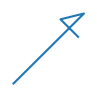

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=[1,1])
plt.axis('off')
plt.plot([-1, 2, 1, 1.75], [-1, 2, 1.75, 1])

In [2]:
import torch
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import kagglehub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report
from PIL import Image
import torch.optim as optim

# Dataset

**Load and Format Dataset into DataLoader**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print(path)
#print("Files in path:", os.listdir(path))

C:\Users\icthr\.cache\kagglehub\datasets\mateuszbuda\lgg-mri-segmentation\versions\2


In [4]:
path='C:\\Users\\icthr\\.cache\\kagglehub\\datasets\\mateuszbuda\\lgg-mri-segmentation\\versions\\2\\kaggle_3m'

In [5]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.image_mask_pairs = []
        self.transform = transform
        self.return_paths = False

        # Loop through all patient folders
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            # Collect image–mask pairs
            for file in os.listdir(patient_path):
                if file.endswith(".tif") and "_mask" not in file:
                    image_path = os.path.join(patient_path, file)
                    mask_path = image_path.replace(".tif", "_mask.tif")
                    if os.path.exists(mask_path):
                        self.image_mask_pairs.append((image_path, mask_path))

    def __len__(self):
        return len(self.image_mask_pairs)

    def set_return_paths(self, flag: bool):
        """Toggle whether __getitem__ returns paths."""
        self.return_paths = flag

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            cropper = CropToBrain()
            x0, y0, x1, y1, image = cropper(image)
            image = self.transform(image)
            mask = mask.crop((x0, y0, x1, y1))
            mask = self.transform(mask)
            mask = (mask > 0).float()  # Binary mask
            
        if self.return_paths:
            return image, mask, img_path, mask_path
        else:
            return image, mask

# Transformations

In [6]:
class CropToBrain:
    def __call__(self, img):
        # Convert PIL image to grayscale numpy array
        gray = np.array(img.convert("L"))
        gray = (gray - gray.min()) / (gray.max() - gray.min())

        # Threshold to find brain area (this may need tuning)
        mask = gray > .1  

        if not mask.any():
            # If no brain detected, return original image
            return img

        # Find bounding box
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1  # slices are exclusive

        # Crop image using the box
        img_cropped = img.crop((x0, y0, x1, y1))

        return x0, y0, x1, y1, img_cropped

In [7]:
class FlexibleNormalize:
    def __init__(self, mean, std):
        self.base_mean = mean
        self.base_std = std

    def __call__(self, tensor):
        c = tensor.shape[0]  # number of channels
        mean = self.base_mean * c if len(self.base_mean) == 1 else self.base_mean
        std  = self.base_std  * c if len(self.base_std)  == 1 else self.base_std
        return transforms.Normalize(mean, std)(tensor)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    FlexibleNormalize(mean=[0.5], std=[0.5])  # works for grayscale or RGB
])

In [8]:
dataset = BrainMRIDataset(path, transform=transform)

In [9]:
dataset.set_return_paths(True)
image, mask, img_path, mask_path = dataset[100]
dataset.set_return_paths(False)

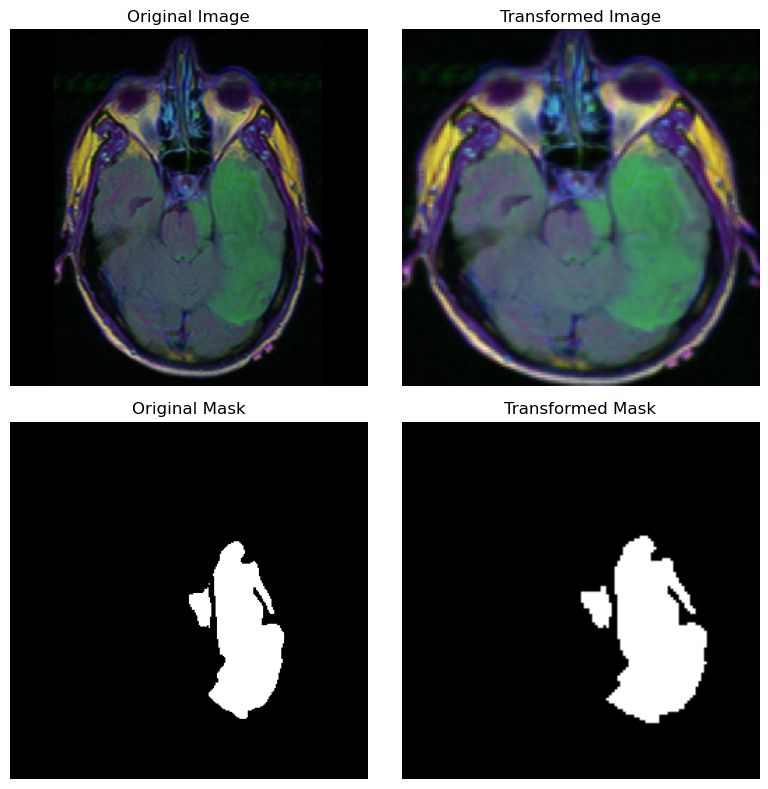

In [10]:
image_original = Image.open(img_path).convert("RGB")   
mask_original = Image.open(mask_path).convert("L")
img_transformed = image.permute(1, 2, 0).numpy()+1
mask_transformed = mask.permute(1, 2, 0).numpy()
img_transformed_norm = (img_transformed - img_transformed.min()) / (img_transformed.max() - img_transformed.min())

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns

axs[0, 0].imshow(image_original)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

axs[0, 1].imshow(img_transformed_norm)
axs[0, 1].set_title("Transformed Image")
axs[0, 1].axis("off")

axs[1, 0].imshow(mask_original, cmap="gray")
axs[1, 0].set_title("Original Mask")
axs[1, 0].axis("off")

axs[1, 1].imshow(mask_transformed, cmap="gray")
axs[1, 1].set_title("Transformed Mask")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

# Batch loader

In [22]:
# Determine sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size) #Want a nice even 80/20 split
val_size = dataset_size - train_size

# Split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Dataset size= {dataset_size}")
print(f"Train Dataset size= {train_size}")
print(f"Validation Dataset size= {val_size}")

Dataset size= 3929
Train Dataset size= 3143
Validation Dataset size= 786


In [23]:
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

# Model and Training

Input 
    (Channels: 3, Pixels: 128x128)
Encoder
    Conv(3x3) + ReLU
        Channels: 3->16, Pixels: 128*128
    Conv(3x3) + ReLU
        Channels: 16->32, Pixels: 128*128
    MaxPool 
        Channels: 32, Pixels: 128*128->64*64
    Conv(3x3) + ReLU
        Channels: 32->64, Pixels: 64*64
    Conv(3x3) +ReLU
        Channels: 64->128, Pixels: 64*64
    MaxPool 
        Channels: 128, Pixels: 64*64->32*32
Bottleneck
    Conv(3x3) + ReLU
        Channels: 128->256, Pixels: 32*32
    Conv(3*3) + ReLU
        Channels: 256->256, Pixels: 32*32
Decoder
    ConvTranspose2d(2*2)
        Channels: 256->128, Pixels: 32*32->64*64
    Concatenate(Chain Decoder with Encoder)
        Channels: 128->256, Pixels: 64*64
    Conv(3*3) + ReLU
        Channels: 256->64, Pixels: 32*32
    ConvTranspose2d(2*2)
        Channels: 64->32, Pixels: 64*64->128*128
    Concatenate(Chain Decoder with Encoder)
        Channels: 32->64, Pixels: 128*128
    Conv(3*3)
        Channels: 64->16, Pixels: 128*128
Output
    Conv(3*3)
        Channels: 16->1, Pixels: 128*128

In [12]:
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, shape_in=[3,128,128], init_f=16, num_classes=1):
        super(Network, self).__init__()

        Cin,Hin,Win=shape_in
        #Encoder__________________________________________________
        #Extract high-level features while reducing spatial dimensions.
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        #Bottleneck________________________________________________
        #Capture the deepest, most abstract features without further downsampling.
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(16*init_f, 16*init_f, kernel_size=3, padding=1)
        #Decoder___________________________________________________
        #Gradually recover spatial detail and produce pixel-level predictions, while leveraging encoder features via skip connections.
        self.conv7 = torch.nn.ConvTranspose2d(16*init_f, 8*init_f, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(8*init_f*2, 4*init_f, kernel_size=3, padding=1)
        self.conv9 = nn.ConvTranspose2d(4*init_f, 2*init_f, kernel_size=2, stride=2)
        self.conv10 = nn.Conv2d(2*init_f*2, init_f, kernel_size=3, padding=1)
        #Final Output
        #Convert final feature maps to 1-channel probability mask (for binary segmentation)
        self.conv11 = nn.Conv2d(init_f, num_classes, kernel_size=3, padding=1)
    def set_troubleshoot(self, flag: bool):
        """Toggle whether __getitem__ returns paths."""
        self.troubleshoot = flag
           
    def forward(self,x):      
        #Encoder
        x1=torch.relu(self.conv1(x)) 
        x2=torch.relu(self.conv2(x1)) 
        x=self.maxpool1(x2) 
        x3=torch.relu(self.conv3(x))
        x4=torch.relu(self.conv4(x3))
        x=self.maxpool2(x4)
        #Bottleneck
        x=torch.relu(self.conv5(x)) 
        x=torch.relu(self.conv6(x)) 
        #Decoder
        x = self.conv7(x) 
        x = torch.cat((x, x4), dim=1)
        x = torch.relu(self.conv8(x)) 
        x = self.conv9(x)
        x = torch.cat((x, x2), dim=1)
        x = torch.relu(self.conv10(x))
        #Final Output
        x = self.conv11(x)
        return x

**DICE = 2TP / (2TP + FP + FN)**

**IOU = TP / (TP +FP +FN)**

In [17]:
criterion_bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2.*intersection + smooth) / (pred.sum() + target.sum() + smooth)
def iou_loss(pred, targets, eps=1e-6):
    # preds, targets: [B, 1, H, W] with preds = sigmoid(logits)
    pred = torch.sigmoid(pred)
    intersection = (pred * targets).sum()
    union = pred.sum() + targets.sum() - intersection
    iou = (intersection + eps) / (union + eps)
    return 1 - iou

def criterion(pred, target):
    return criterion_bce(pred, target) + dice_loss(pred, target)

# One Sample Example (PreTraining)

In [20]:
model_pretraining = Network(shape_in=[3,128,128], init_f=16, num_classes=1)

In [198]:
image, mask= dataset[100]
image_batch1=image.unsqueeze(0)
test_outputs = model_pretraining(image_batch1)
test_outputs_squeezed=test_outputs.squeeze(1)
prediction = (torch.sigmoid(test_outputs_squeezed) > 0.5).float()
example_loss = criterion(test_outputs_squeezed, mask)

seg_correct = ((prediction == 1) & (mask == 1)).sum().item()
seg_total   = (mask == 1).sum().item()
seg_acc = seg_correct / seg_total if seg_total > 0 else 0

# Background accuracy
bg_correct = ((prediction == 0) & (mask == 0)).sum().item()
bg_total   = (mask == 0).sum().item()
bg_acc = bg_correct / bg_total if bg_total > 0 else 0

balanced_acc= (seg_acc + bg_acc) / 2
IOU = 1 - iou_loss(prediction, mask, eps=1e-6)
DICE = 1 - dice_loss(prediction, mask, smooth=1e-6)

(0.0, 1.0, 0.0, 1.0)

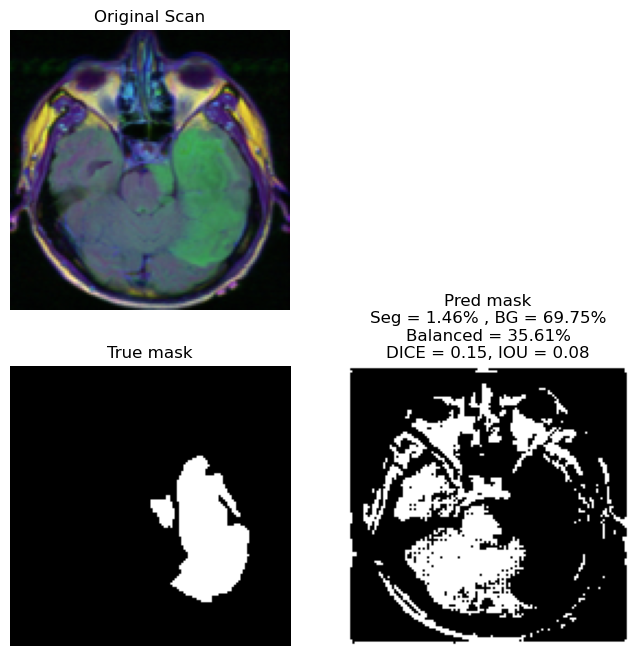

In [199]:
mask_transformed = mask.permute(1, 2, 0).detach().numpy()
prediction_transformed = prediction.permute(1, 2, 0)
img_transformed = image.permute(1, 2, 0).numpy()
img_transformed_norm = (img_transformed - img_transformed.min()) / (img_transformed.max() - img_transformed.min())

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns
axs[0, 0].imshow(img_transformed_norm)
axs[0, 0].set_title("Original Scan")
axs[0, 0].axis("off")
axs[1,0].imshow(mask_transformed, cmap="gray")
axs[1,0].set_title("True mask")
axs[1,0].axis("off")
axs[1,1].imshow(prediction_transformed, cmap="gray")
axs[1,1].set_title(f"Pred mask\nSeg = {round(seg_acc*100,2)}% , BG = {round(bg_acc*100,2)}%\nBalanced = {round(balanced_acc*100,2)}%\nDICE = {round(DICE.item(),2)}, IOU = {round(IOU.item(),2)}") 
axs[1,1].axis("off")
axs[0,1].axis("off")

# Training

In [42]:
#Function for training the model
def train_model(model,train_loader,val_loader,optimizer,n_epochs=4):
    cost_list=[]
    #global variable 
    N_test=len(val_dataset)
    avg_acc_list=[]
    background_acc_list=[]
    segment_acc_list=[]
    loss_list=[]
    best_COST=1000.0
    
    for epoch in range(n_epochs):
        COST=0
        for batch_idx, (x, y) in enumerate(train_loader, start=1): #for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)
            COST+=loss.data 
            print(epoch, "+", batch_idx)
        cost_list.append(COST)    
        avg_acc_batch_list=[]
        background_acc_batch_list=[]
        segment_acc_batch_list=[]
        for x_test, y_test in val_loader:
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_test)
                preds = (torch.sigmoid(test_outputs) > 0.5).float()
        
                # Segment (foreground) accuracy
                seg_correct = ((preds == 1) & (y_test == 1)).sum().item()
                seg_total   = (y_test == 1).sum().item()
                seg_acc = seg_correct / seg_total if seg_total > 0 else 0
        
                # Background accuracy
                bg_correct = ((preds == 0) & (y_test == 0)).sum().item()
                bg_total   = (y_test == 0).sum().item()
                bg_acc = bg_correct / bg_total if bg_total > 0 else 0

                # Average accuracy per category
                avg_acc=(seg_acc+bg_acc)/2
        
                # Keep track of each batches accuracies
                segment_acc_batch_list.append(seg_acc)
                background_acc_batch_list.append(bg_acc)
                avg_acc_batch_list.append(avg_acc)
        #Average the accuracies from each batch for this training session and that to the list. 
        segment_acc_list.append(np.array(segment_acc_batch_list).mean())
        background_acc_list.append(np.array(background_acc_batch_list).mean())
        avg_acc_list.append(np.array(avg_acc_batch_list).mean())


        
        #In case I decide I want to quit early, I can load up the checkpoint with the previous best...
        if best_COST > COST:
            best_COST=COST
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }, "checkpoint.pth")
        
    return avg_acc_list, segment_acc_list, background_acc_list, loss_list, cost_list

**Initialize and Train model**

In [14]:
# Create the model object using CNN class
model = Network(shape_in=[3,128,128], init_f=16, num_classes=1)

In [48]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [59]:
avg_acc_list, segment_acc_list, background_acc_list, loss_list, cost_list = train_model(model,train_loader,val_loader,optimizer,n_epochs=10)

0 + 1
0 + 2
0 + 3
0 + 4
0 + 5
0 + 6
0 + 7
0 + 8
0 + 9
0 + 10
0 + 11
0 + 12
0 + 13
0 + 14
0 + 15
0 + 16
0 + 17
0 + 18
0 + 19
0 + 20
0 + 21
0 + 22
0 + 23
0 + 24
0 + 25
0 + 26
0 + 27
0 + 28
0 + 29
0 + 30
0 + 31
0 + 32
0 + 33
0 + 34
0 + 35
0 + 36
0 + 37
0 + 38
0 + 39
0 + 40
0 + 41
0 + 42
0 + 43
0 + 44
0 + 45
0 + 46
0 + 47
0 + 48
0 + 49
0 + 50
0 + 51
0 + 52
0 + 53
0 + 54
0 + 55
0 + 56
0 + 57
0 + 58
0 + 59
0 + 60
0 + 61
0 + 62
0 + 63
1 + 1
1 + 2
1 + 3
1 + 4
1 + 5
1 + 6
1 + 7
1 + 8
1 + 9
1 + 10
1 + 11
1 + 12
1 + 13
1 + 14
1 + 15
1 + 16
1 + 17
1 + 18
1 + 19
1 + 20
1 + 21
1 + 22
1 + 23
1 + 24
1 + 25
1 + 26
1 + 27
1 + 28
1 + 29
1 + 30
1 + 31
1 + 32
1 + 33
1 + 34
1 + 35
1 + 36
1 + 37
1 + 38
1 + 39
1 + 40
1 + 41
1 + 42
1 + 43
1 + 44
1 + 45
1 + 46
1 + 47
1 + 48
1 + 49
1 + 50
1 + 51
1 + 52
1 + 53
1 + 54
1 + 55
1 + 56
1 + 57
1 + 58
1 + 59
1 + 60
1 + 61
1 + 62
1 + 63
2 + 1
2 + 2
2 + 3
2 + 4
2 + 5
2 + 6
2 + 7
2 + 8
2 + 9
2 + 10
2 + 11
2 + 12
2 + 13
2 + 14
2 + 15
2 + 16
2 + 17
2 + 18
2 + 19
2 + 20
2 + 2

# Results

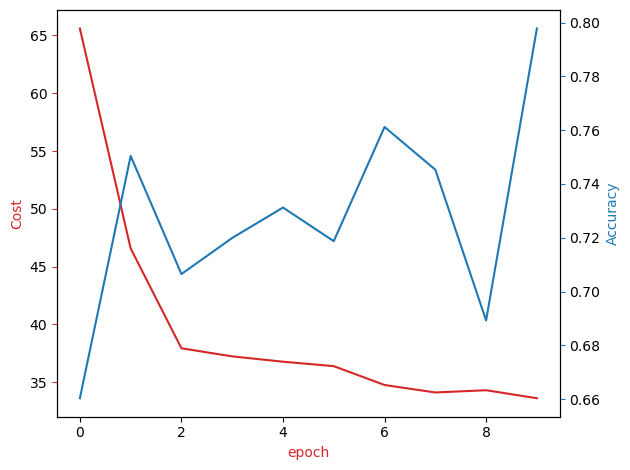

In [50]:
#Plot Accuracy & Cost
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( avg_acc_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

# One Sample Example (Post Training)

In [ ]:
# #Save the model
# torch.save(model.state_dict(), 'Tumor_Segmentation_best.pth')

In [18]:
# # Load the model
# model = Network(shape_in=[3,128,128], init_f=16, num_classes=1)
# model.load_state_dict(torch.load('Tumor_Segmentation_best.pth'))
# # Ensure the loaded model is in evaluation mode
# model.eval()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv8): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv10): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(16, 1, kernel_size=(3, 3), str

In [19]:
image, mask= dataset[100]
image_batch1=image.unsqueeze(0)
test_outputs = model(image_batch1)
test_outputs_squeezed=test_outputs.squeeze(1)
prediction = (torch.sigmoid(test_outputs_squeezed) > 0.5).float()
example_loss = criterion(test_outputs_squeezed, mask)

seg_correct = ((prediction == 1) & (mask == 1)).sum().item()
seg_total   = (mask == 1).sum().item()
seg_acc = seg_correct / seg_total if seg_total > 0 else 0

# Background accuracy
bg_correct = ((prediction == 0) & (mask == 0)).sum().item()
bg_total   = (mask == 0).sum().item()
bg_acc = bg_correct / bg_total if bg_total > 0 else 0

balanced_acc= (seg_acc + bg_acc) / 2
IOU = 1 - iou_loss(prediction, mask, eps=1e-6)
DICE = 1 - dice_loss(prediction, mask, smooth=1e-6)

(0.0, 1.0, 0.0, 1.0)

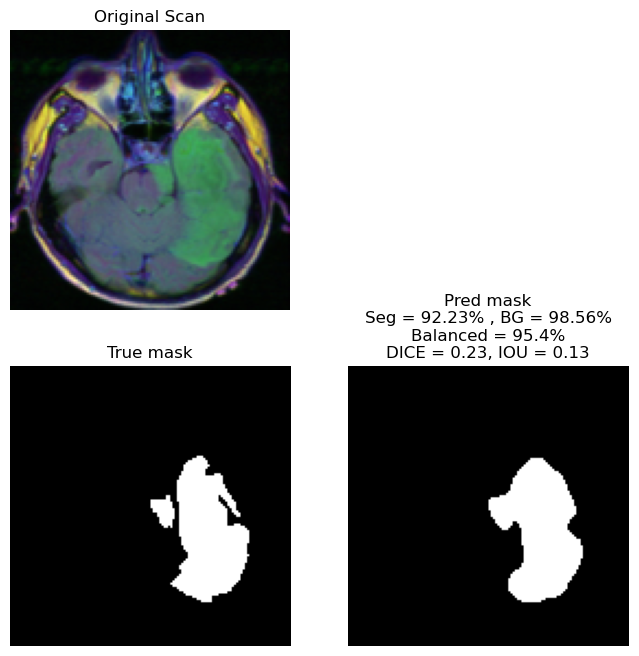

In [20]:
mask_transformed = mask.permute(1, 2, 0).detach().numpy()
prediction_transformed = prediction.permute(1, 2, 0)
img_transformed = image.permute(1, 2, 0).numpy()
img_transformed_norm = (img_transformed - img_transformed.min()) / (img_transformed.max() - img_transformed.min())

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns
axs[0, 0].imshow(img_transformed_norm)
axs[0, 0].set_title("Original Scan")
axs[0, 0].axis("off")
axs[1,0].imshow(mask_transformed, cmap="gray")
axs[1,0].set_title("True mask")
axs[1,0].axis("off")
axs[1,1].imshow(prediction_transformed, cmap="gray")
axs[1,1].set_title(f"Pred mask\nSeg = {round(seg_acc*100,2)}% , BG = {round(bg_acc*100,2)}%\nBalanced = {round(balanced_acc*100,2)}%\nDICE = {round(DICE.item(),2)}, IOU = {round(IOU.item(),2)}") 
axs[1,1].axis("off")
axs[0,1].axis("off")

# Model Metrics

In [24]:
#Run validation again to save predictions/accuracy for confusion matrix
y_true=[]
test_outputs_all=[]
y_pred = []
cm_total = np.zeros((2, 2), dtype=int)
IOU_list=[]
DICE_list=[]
seg_acc_list=[]
bg_acc_list=[]
balanced_acc_list=[]

model.eval()               
with torch.no_grad(): 
    for x_test, y_test in val_loader:
        test_outputs = model(x_test)              # shape: [B, 1, H, W]
        probs = torch.sigmoid(test_outputs)       # probabilities [0-1]
        preds = (probs > 0.5).float()             # binary mask
        IOU = iou_loss(preds, y_test, eps=1e-6)
        DICE = dice_loss(preds, y_test, smooth=1e-6)
        IOU_list.append(IOU)
        DICE_list.append(DICE)
        
        # Flatten to 1D per batch and add to 
        y_true_flat = y_test.view(-1).cpu().numpy()
        y_pred_flat =preds.view(-1).cpu().numpy()
        
        cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1])
        cm_total += cm

        #Segment accuracy
        seg_correct = ((preds == 1) & (y_test == 1)).sum().item()
        seg_total   = (y_test == 1).sum().item()
        seg_acc = seg_correct / seg_total if seg_total > 0 else 0
        seg_acc_list.append(seg_acc)

        # Background accuracy
        bg_correct = ((preds == 0) & (y_test == 0)).sum().item()
        bg_total   = (y_test == 0).sum().item()
        bg_acc = bg_correct / bg_total if bg_total > 0 else 0
        bg_acc_list.append(bg_acc)

        # Balanced accuracy
        balanced_acc= (seg_acc + bg_acc) / 2
        balanced_acc_list.append(balanced_acc)

DICE = 0.04
IOU = 0.02
Seg accuracy = 0.3956
BG accuracy = 0.9975
Balanced accuracy = 0.6966


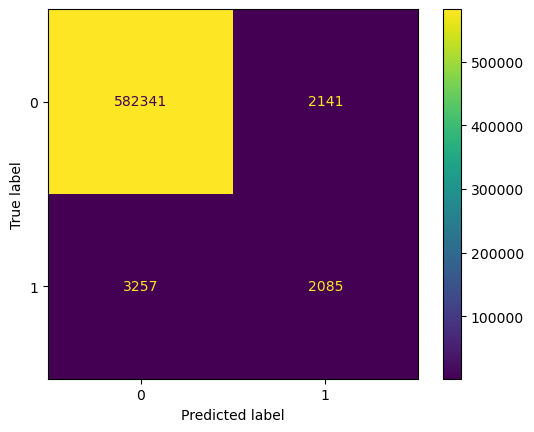

In [29]:
disp=ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot()
print(f"DICE = {1-np.array(DICE_list).mean():.2f}\nIOU = {1-np.array(IOU_list).mean():.2f}\nSeg accuracy = {np.array(seg_acc_list).mean():.4f}\nBG accuracy = {np.array(bg_acc_list).mean():.4f}\nBalanced accuracy = {np.array(balanced_acc_list).mean():.4f}")

# Full Segment Example

In [194]:
image_list=[]
mask_list=[]
prediction_list=[]
for i in range(13):
    image, mask= dataset[i]
    image_batch1=image.unsqueeze(0)
    test_outputs = model(image_batch1)
    test_outputs_squeezed=test_outputs.squeeze(1)
    prediction = (torch.sigmoid(test_outputs_squeezed) > 0.5).float()
    
    mask_transformed = mask.permute(1, 2, 0).cpu().detach().numpy()
    prediction_transformed = prediction.permute(1, 2, 0).cpu().numpy()
    img_transformed = image.permute(1, 2, 0).cpu().numpy()
    img_transformed_norm = (img_transformed - img_transformed.min()) / (img_transformed.max() - img_transformed.min())
    image_list.append(img_transformed_norm)
    mask_list.append(mask_transformed)
    prediction_list.append(prediction_transformed)

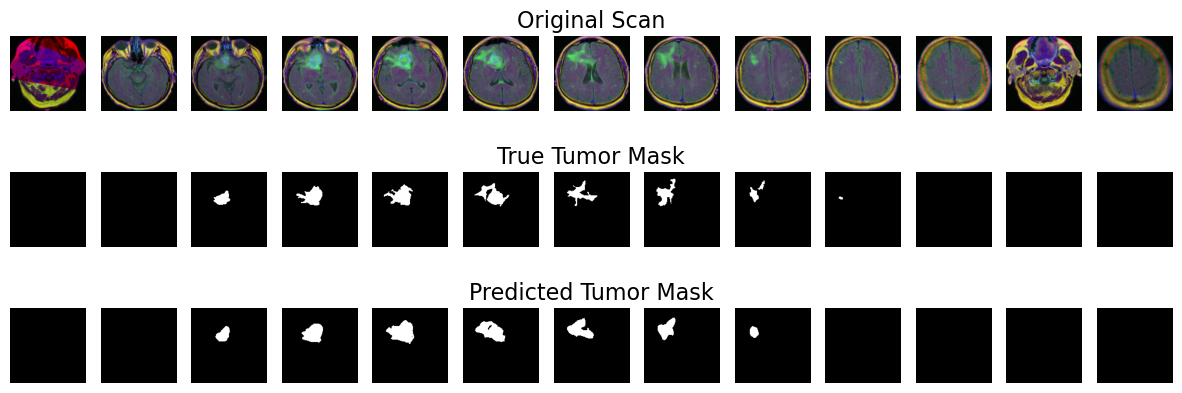

In [207]:
fig, axs = plt.subplots(3, 13, figsize=(15, 5))

for i in range(13):
    col = i % 13
    row_offset = 0 if i < 13 else 3  # top half or bottom half

    axs[row_offset + 0, col].imshow(image_list[i])
    axs[row_offset + 0, col].axis("off")

    axs[row_offset + 1, col].imshow(mask_list[i], cmap="gray")
    axs[row_offset + 1, col].axis("off")

    axs[row_offset + 2, col].imshow(prediction_list[i], cmap="gray")
    axs[row_offset + 2, col].axis("off")

row_titles = ["Original Scan", "True Tumor Mask", "Predicted Tumor Mask"]

for row, title in enumerate(row_titles):
    axs[row, 6].set_title(title, fontsize=16)  # set title on first column